In [216]:
#run this command if not installed
#!pip install dimod

### Required Modules

In [251]:
#to visualize the network and easy handling of graphs I am using networkx
import networkx as gp
import matplotlib.pyplot as plt
import dimod
import math

In [218]:
#using inbuilt function to find shortest path
#help(gp.shortest_simple_paths)

In [219]:
#we will use pairwise function to convert the continuous nodes (representing path) into edges (where each edge is a node pair)
l= [1,2,4,5,2,4]
ed = list(gp.utils.pairwise(l))
print(ed)

[(1, 2), (2, 4), (4, 5), (5, 2), (2, 4)]


### Sample Input Data

In [692]:
#sample data - to be read from file
#total number of nodes
num_nodes = 6
#Edges are given as u,v,congestion where edges is from u to v and its congestion level is given by the attribute congestion
edges = [
    (0, 1, {'congestion': 2, 'distance': 2}),
    (1, 2, {'congestion': 10, 'distance': 2}),
    (2, 3, {'congestion': 1, 'distance': 2}),
    (3, 4, {'congestion': 4, 'distance': 10}),
    (0, 5, {'congestion': 1, 'distance': 3}),
    (5, 6, {'congestion': 5, 'distance': 3}),
    (6, 4, {'congestion': 1, 'distance': 2}),
    (1, 3, {'congestion': 15, 'distance': 2}),
    (0, 3, {'congestion': 5, 'distance': 3})
]
'''
edges = [
    (0,1,{'congestion':100, 'distance':40}),
    (0,2,{'congestion':10, 'distance':30}),
    (1,3,{'congestion':200, 'distance':260}),
    (1,4,{'congestion':110, 'distance':100}),
    (2,4,{'congestion':10, 'distance':500}),
    (2,5,{'congestion':12, 'distance':300}),
    (3,4,{'congestion':35, 'distance':6000}),
    (4,2,{'congestion':54, 'distance':300}),
    (0,5,{'congestion':200, 'distance':50}),
    (0,3,{'congestion':50, 'distance':3000})
]'''
#total number of cars to reroute
no_of_cars = 3
#source-destination pair of each car
src_dest = [(0,4,0),(0,4,0),(0,3,1)]

## Graph formation using NetworkX

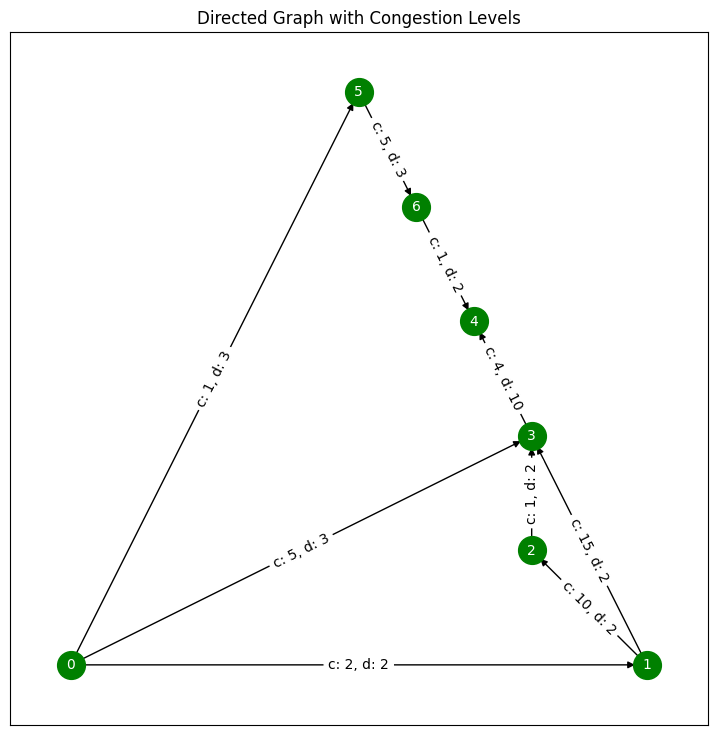

In [693]:
#forming the city's network
#adding nodes
net = gp.DiGraph()
net.add_edges_from(edges)
plt.figure(figsize=(9,9))
pos = gp.planar_layout(net)
gp.draw_networkx_nodes(net, pos, node_color='green', node_size=400)
gp.draw_networkx_edges(net, pos, arrowstyle='-|>', arrowsize=10)
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels)
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white')
plt.title("Directed Graph with Congestion Levels")
plt.show()

### Alternative Routes

In [694]:
def nodeToEdge(node_routes,no_of_car, no_of_route):
    '''the function convert the route in nodes format to edge format (pairwise nodes as shown above)'''
    edge_route = []
    for i in range(no_of_car):
        car_route = []
        for j in range(no_of_route):
                car_route.append(list(gp.utils.pairwise(node_routes[i][j])))
        edge_route.append(car_route)
    return edge_route

In [695]:
def calcJCS(set_a, set_b):
    '''
    the function calculates the jaccard similarity index of two given paths
    '''
    inter = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return inter/union if union !=0 else 0
def jaccardSimilarityIndex(paths):
    '''
    the function returns the three paths which have least Jaccard Similarity index
    '''
    k = len(paths)
    if(k<=3):return paths
    route = [paths]
    route = nodeToEdge(route,1,k)
    route = route[0]
    result = {}
    for i in range(k):
        for j in range(i+1,k):
            set_a = set(route[i])
            set_b = set(route[j])
            similarity = calcJCS(set_a, set_b)
            result.update({(i,j):similarity})
    srf = sorted(result.items(), key=lambda x: x[1])
    sr=srf[0][0]
    sr2 = srf[1][0]
    final_paths = [paths[sr[0]],paths[sr[1]]]
    if sr2[0] not in sr:
        final_paths.append(paths[sr2[0]])
    else:
        final_paths.append(paths[sr2[1]])
    return final_paths

def edgeWeight(u,v,d):
    return d.get('congestion')/d.get('distance')

def alternativeRoutes(no_of_cars, sd):
    '''finds all the simple paths from source to destination for each car'''
    routes = []
    for i in range(no_of_cars):
        k_paths = list(gp.shortest_simple_paths(net, source = sd[i][0], target=sd[i][1], weight = edgeWeight))
        k_paths = jaccardSimilarityIndex(k_paths)
        routes.append(k_paths)
    return routes
    #return [[[0,1,4],[0,1,3,4],[0,2,4]],[[0,2,5],[0,1,3,4,5],[0,1,4,5]]]

In [696]:
routes  = alternativeRoutes(no_of_cars,src_dest )
print("Source-Destination Pairs for Rerouting:")
ind = 1
for src, dest,emergency in src_dest:
    print(f"Car {ind} from {src} to {dest} : emergency {emergency}")
    ind+=1
print(routes)
print('\nAlternative Routes :\n')
index = 0
for i in range(1,no_of_cars+1):
    print(f'Possible Routes for Car {i}')
    if(len(routes[i-1])<3):
        print("Please give nodes with at least three paths")
        break
    for ch in range(0,len(routes[i-1])):
        l=[]
        for path in routes[i-1][ch]:
            l.append(str(path))
        c="->"
        print(index,":",c.join(l))
        index+=1
        print()

Source-Destination Pairs for Rerouting:
Car 1 from 0 to 4 : emergency 0
Car 2 from 0 to 4 : emergency 0
Car 3 from 0 to 3 : emergency 1
[[[0, 3, 4], [0, 5, 6, 4], [0, 1, 2, 3, 4]], [[0, 3, 4], [0, 5, 6, 4], [0, 1, 2, 3, 4]], [[0, 3], [0, 1, 2, 3], [0, 1, 3]]]

Alternative Routes :

Possible Routes for Car 1
0 : 0->3->4

1 : 0->5->6->4

2 : 0->1->2->3->4

Possible Routes for Car 2
3 : 0->3->4

4 : 0->5->6->4

5 : 0->1->2->3->4

Possible Routes for Car 3
6 : 0->3

7 : 0->1->2->3

8 : 0->1->3



### Helping Functions

In [697]:
def getOverlappingEdges(route1, route2):
    '''the function returns a list of overlapping edges (pairwise-nodes)'''
    overlaps =[]
    for r1 in route1:
        if r1 in route2:
            overlaps.append(r1)
    return overlaps

In [698]:
def getNonOverlappingEdges(route):
    '''
    returns the unique elements in an array
    '''
    uni = []
    for edge in route:
        if edge not in uni:
            uni.append(edge)
    return uni

In [699]:
def matrixWeight(route_edge, no_of_cars, no_of_routes):
    '''
        Forms the weight matrix (W(ij)) for each binary variable.
        We multiply the weights for the least, second, and best routes by 2, 4, and 8 respectively.
        For emergency vehicles, the weight is doubled overall.
    '''
    Q_weight = {}
    for i in range(no_of_cars):
        emergency = src_dest[i][2]
        path_multipliers = [1.5,2,3]
        l=[]
        for j in range(no_of_routes):
            path = route_edge[i][j]
            path_weight = 0
            total_congestion = 0
            total_distance = 0
            for x, y in path:
                congestion = net[x][y]['congestion']
                distance = net[x][y]['distance']
                total_congestion += congestion
                total_distance += distance
            path_weight = (1.5 * total_congestion) + (1*total_distance)
            l.append((path_weight,j))
        sorted(l)
        ind = 0
        for w,index in l:
            ele=1
            ele*=path_multipliers[ind]
            if emergency == 0:
                ele*=2
            ind+=1
            Q_weight.update({(i, index): ele})
    print(Q_weight)
    return Q_weight
    

In [700]:
def displayMatrix(Q):
    print("-"*100)
    for i in range(0,no_of_cars*no_of_routes):
        for j in range(0,no_of_cars*no_of_routes):
            print(round(Q.get((i,j)),3),"\t|", end="\t")
        print()
        print("-"*100)
    print()

In [701]:
def formQuboMatrix(routes, no_of_car, no_of_routes):
    '''
    forms the QUBO matrix in the form of dictionary
    '''
    #dictionary Q will store the qubo matrix
    Q = {}
    K = 0 # initializing penalty factor
    W = matrixWeight(routes, no_of_car, no_of_routes)
    tot_var = no_of_car*no_of_routes
    #initializing the matrix values to 0
    for i in range(tot_var):
        for j in range(tot_var):
            Q.update({(i,j):0})
    #adding cost function terms
    K = 0
    for i in range(no_of_car):
        car_i_overlap = 0
        for j in range(no_of_routes):
            tot_overlap = []
            for k in range(i+1, no_of_car):
                for m in range(no_of_routes):
                    list_of_overlap = getOverlappingEdges(routes[i][j], routes[k][m])
                    #print(list_of_overlap)
                    Q.update({(i*no_of_routes + j, k*no_of_routes + m):2*len(list_of_overlap)*W[(i,j)]*W[(k,m)]})
                    tot_overlap.extend(list_of_overlap)
            uni_overlap = getNonOverlappingEdges(tot_overlap)
            Q.update({(i*no_of_routes + j, i*no_of_routes + j):len(uni_overlap)*W[(i,j)]*W[(i,j)]})
            car_i_overlap+=len(uni_overlap)
        K = max(K, car_i_overlap)
    #adding penalty terms
    K=K*1000
    print("Penalty Factor :", K)
    for i in range(no_of_car):
        for j in range(no_of_routes):
            for m in range(j+1, no_of_routes):
                Q.update({(i*no_of_routes + j, i*no_of_routes + m):K*2})
            Q[(i*no_of_routes + j, i*no_of_routes + j)] -= K;
    return Q 

In [702]:
routes  = alternativeRoutes(no_of_cars,src_dest)
no_of_routes = len(routes[0])
routes_edge = nodeToEdge(routes,no_of_cars,no_of_routes)
Q = formQuboMatrix(routes_edge, no_of_cars, no_of_routes)
#Q will be an upper triangle matrix
print("QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )")
displayMatrix(Q)

{(0, 0): 3.0, (0, 1): 4, (0, 2): 6, (1, 0): 3.0, (1, 1): 4, (1, 2): 6, (2, 0): 1.5, (2, 1): 2, (2, 2): 3}
Penalty Factor : 9000
QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )
----------------------------------------------------------------------------------------------------
-8982.0 	|	18000 	|	18000 	|	36.0 	|	0.0 	|	36.0 	|	9.0 	|	0.0 	|	0.0 	|	
----------------------------------------------------------------------------------------------------
0 	|	-8952 	|	18000 	|	0.0 	|	96 	|	0 	|	0.0 	|	0 	|	0 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	-8856 	|	36.0 	|	0 	|	288 	|	0.0 	|	72 	|	36 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	0 	|	-8991.0 	|	18000 	|	18000 	|	9.0 	|	0.0 	|	0.0 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	0 	|	0 	|	-9000 	|	18000 	|	0.0 	

In [703]:
#runnign the classical solver 
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
exact_solver  = dimod.ExactSolver()
response = exact_solver.sample(bqm)
result = list(response.samples())
print(response)
resulting_energy = list(response.data_vectors['energy'])
min_energy = min(resulting_energy)
ct = resulting_energy.count(min_energy)
best_result = []
for i in range(ct):
    best_result.append(list(dict.values(dict(result[i]))))

     0  1  2  3  4  5  6  7  8   energy num_oc.
225  1  0  0  0  1  0  0  1  0 -26982.0       1
481  1  0  0  0  1  0  0  0  1 -26982.0       1
97   1  0  0  0  1  0  1  0  0 -26973.0       1
243  0  1  0  1  0  0  0  1  0 -26943.0       1
499  0  1  0  1  0  0  0  0  1 -26943.0       1
241  1  0  0  1  0  0  0  1  0 -26937.0       1
497  1  0  0  1  0  0  0  0  1 -26937.0       1
115  0  1  0  1  0  0  1  0  0 -26934.0       1
113  1  0  0  1  0  0  1  0  0 -26919.0       1
99   0  1  0  0  1  0  1  0  0 -26856.0       1
103  0  0  1  0  1  0  1  0  0 -26856.0       1
227  0  1  0  0  1  0  0  1  0 -26856.0       1
483  0  1  0  0  1  0  0  0  1 -26856.0       1
67   0  1  0  0  0  1  1  0  0 -26844.0       1
65   1  0  0  0  0  1  1  0  0 -26829.0       1
487  0  0  1  0  1  0  0  0  1 -26820.0       1
451  0  1  0  0  0  1  0  0  1 -26808.0       1
119  0  0  1  1  0  0  1  0  0 -26802.0       1
449  1  0  0  0  0  1  0  0  1 -26802.0       1
231  0  0  1  0  1  0  0  1  0 -26784.0 

In [704]:
print("minimum energy :",min_energy)
car1_nodes = []
car2_nodes = []
for sol in best_result:
    print("Possible Solution :", sol)
    ind = 0
    for i in range(no_of_cars):
        for j in range(no_of_routes):
            if(sol[ind]==1):
                    print(f'best route for car {i+1}: {routes[i][j]}')
                    if(i==0):car1_nodes = routes[i][j]
                    if(i==2):car2_nodes = routes[i][j]
            ind+=1

minimum energy : -26982.0
Possible Solution : [1, 0, 0, 0, 1, 0, 0, 1, 0]
best route for car 1: [0, 3, 4]
best route for car 2: [0, 5, 6, 4]
best route for car 3: [0, 1, 2, 3]
Possible Solution : [1, 0, 0, 0, 1, 0, 0, 0, 1]
best route for car 1: [0, 3, 4]
best route for car 2: [0, 5, 6, 4]
best route for car 3: [0, 1, 3]


Best Solution
Blue represent Car 1 , Green represents Car 2


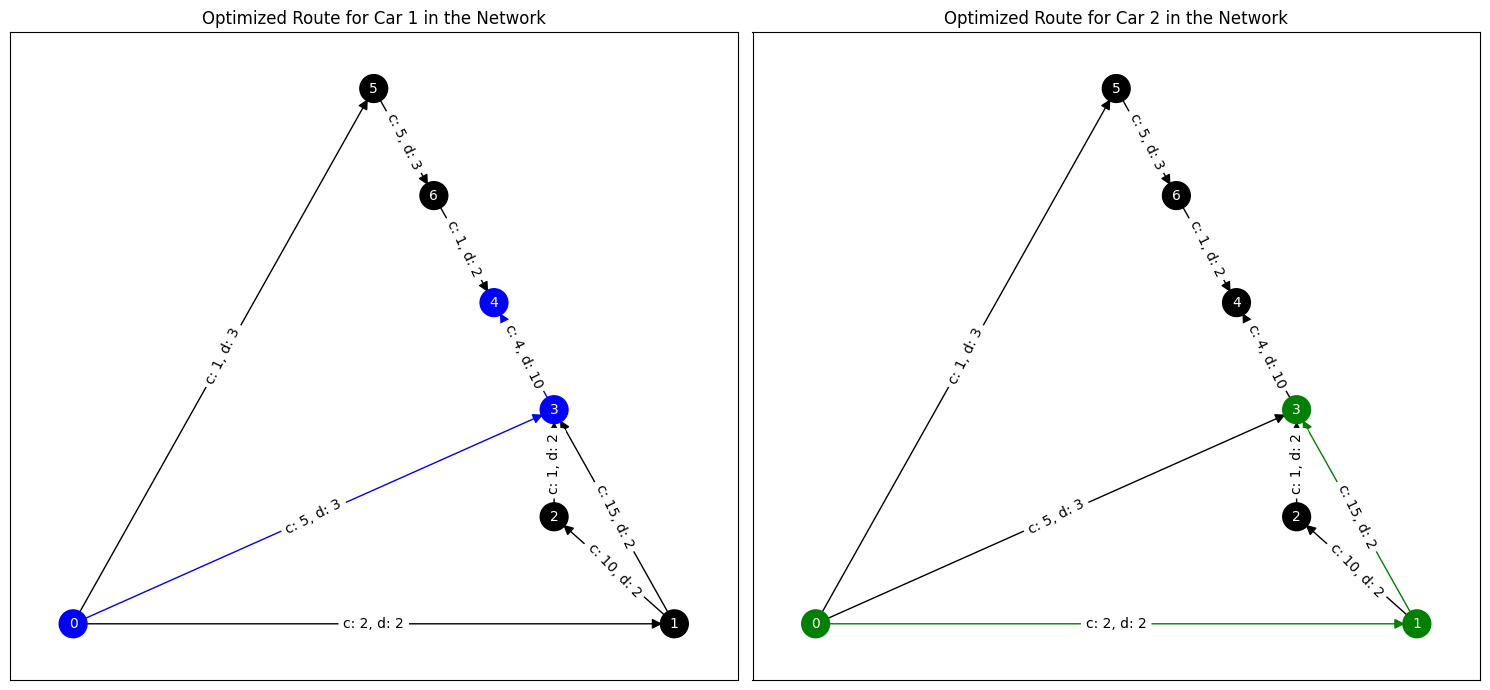

In [705]:
print("Best Solution")
print("Blue represent Car 1 , Green represents Car 2")
car1_edges = list(gp.utils.pairwise(car1_nodes))
car2_edges = list(gp.utils.pairwise(car2_nodes))
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
fig, axes = plt.subplots(1, 2, figsize=(15, 7)) 
pos = gp.planar_layout(net)
#car1
node_colors = ['blue' if node in car1_nodes else 'black' for node in net.nodes()]
edge_colors = ['blue' if (u, v) in car1_edges else 'black' for u, v in net.edges()]
gp.draw_networkx_nodes(net, pos, node_color=node_colors, node_size=400,ax=axes[0])
gp.draw_networkx_edges(net, pos, edge_color = edge_colors, arrowstyle='-|>', arrowsize=15,ax=axes[0])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[0])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[0])
axes[0].set_title("Optimized Route for Car 1 in the Network")

#car2
node_colors_car2 = ['green' if node in car2_nodes else 'black' for node in net.nodes()]
edge_colors_car2 = ['green' if (u, v) in car2_edges else 'black' for u, v in net.edges()]

gp.draw_networkx_nodes(net, pos, node_color=node_colors_car2, node_size=400, ax=axes[1])
gp.draw_networkx_edges(net, pos, edge_color=edge_colors_car2, arrowstyle='-|>', arrowsize=15, ax=axes[1])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[1])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[1])
axes[1].set_title("Optimized Route for Car 2 in the Network")


plt.tight_layout()
plt.show()